# Hybrid Quantum transfer learning for Bell Pepper leaf image classification

The convolutional neural network **MobileNetV2**, which was pre-trained on the open ImageNet dataset, serves as the starting point. It takes up less space and can be used for real-time applications. We replace the last classifier layer with a dressed quantum circuit with 2 classes diseased(0) and healthy(1).

## General setup

In [1]:
# OpenMP: number of parallel threads.
%env OMP_NUM_THREADS=1

# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

# Pennylane
import pennylane as qml
from pennylane import numpy as np

# Other tools
import time
import os
import copy

env: OMP_NUM_THREADS=1


C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
n_qubits = 4                     # Number of qubits
quantum = True                   # If set to "False", the dressed quantum circuit is replaced by 
                                 # An enterily classical net (defined by the next parameter). 
classical_model = '4096_nq_2'    # Possible choices: '4096_2','4096_nq_2','4095_4096_2'. 
step = 0.0004                    # Learning rate
batch_size = 4                   # Number of samples for each training step
num_epochs = 15                  # Number of training epochs
q_depth = 6                      # Depth of the quantum circuit (number of variational layers)
gamma_lr_scheduler = 0.1         # Learning rate reduction applied every 10 epochs.                       
max_layers = 15                  # Keep 15 even if not all are used.
q_delta = 0.01                   # Initial spread of random quantum weights
rng_seed = 0                     # Seed for random number generator
start_time = time.time()         # Start of the computation timer

Initializing PennyLane device with the default simulator.

In [3]:
dev = qml.device('default.qubit', wires=n_qubits)

Configure PyTorch to use CUDA, only if available. Otherwise simply use the CPU.

#Note - I have used PyTorch Cuda in my model

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Preparation

The Bell Pepper Leaf Dataset can be downloaded from the [PlantVillage](https://www.kaggle.com/datasets/abdallahalidev/plantvillage-dataset) present on kaggle or you can even download it from my [Github repo](https://github.com/bopardikarsoham/Bell_Pepper_Leaf_Disease_Quantum_Classifier/tree/main/PlantVillage).

The PyTorch packages `torchvision` and `torch.utils.data` are used for loading the dataset and performing standard preliminary image operations: resize, center, crop, normalize, etc. 

In [5]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.RandomResizedCrop(224),     # uncomment for data augmentation
        #transforms.RandomHorizontalFlip(),     # uncomment for data augmentation
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        # Normalize input channels using mean values and standard deviations of ImageNet.
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'PlantVillage/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                     data_transforms[x]) for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

# Initialize dataloader
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size, shuffle=True) for x in ['train', 'val']}

# function to plot images
def imshow(inp, title=None):
    """Display image from tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    # We apply the inverse of the initial normalization operation.
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)

A demo batch of the test data

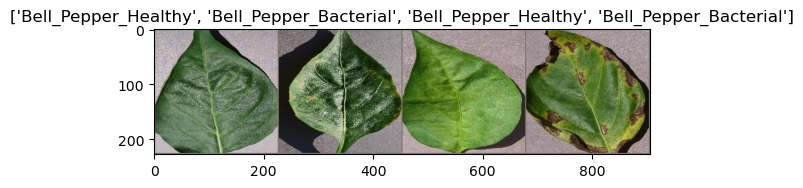

In [6]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['val']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In order to get reproducible results, we set a manual seed for the random number generator and re-initialize the dataloaders.

In [7]:
torch.manual_seed(rng_seed)
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], 
                  batch_size=batch_size,shuffle=True) for x in ['train', 'val']}

## Dressed Quantum Circuit

We first define some quantum layers that will compose the quantum circuit.

In [8]:
def H_layer(nqubits):
    """Layer of single-qubit Hadamard gates. 
    """
    for idx in range(nqubits):
        qml.Hadamard(wires=idx)
        
def RY_layer(w):
    """Layer of parametrized qubit rotations around the y axis. 
    """
    for idx, element in enumerate(w):
        qml.RY(element, wires=idx)

def entangling_layer(nqubits):
    """Layer of CNOTs followed by another shifted layer of CNOT.
    """ 
    for i in range(0, nqubits - 1, 2): 
        qml.CNOT(wires=[i, i + 1])
    for i in range(1, nqubits - 1, 2): 
        qml.CNOT(wires=[i, i + 1])

In [9]:
@qml.qnode(dev, interface='torch')
def q_net(q_in, q_weights_flat):
        
        # Reshape weights
        q_weights = q_weights_flat.reshape(max_layers, n_qubits)
        
        # Start from state |+> , unbiased w.r.t. |0> and |1>
        H_layer(n_qubits)   
        
        # Embed features in the quantum node
        RY_layer(q_in)      
       
        # Sequence of trainable variational layers
        for k in range(q_depth):
            entangling_layer(n_qubits)
            RY_layer(q_weights[k + 1])

        # Expectation values in the Z basis
        return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

We can now define a custom `torch.nn.Module` representing a dressed quantum circuit.
This is is a concatenation of:

1) A classical pre-processing layer (nn.Linear)
2) A classical activation function (F.tanh)
3) A constant np.pi/2.0 scaling factor.
4) The previously defined quantum circuit (q_net)
5) A classical post-processing layer (nn.Linear)

The input of the module is a batch of vectors with 1280 real parameters (features) and the output is a batch of vectors with 2 classes diseased(0) and healthy(1).

In [14]:
class Quantumnet(nn.Module):
        def __init__(self):
            super().__init__()
            self.pre_net = nn.Linear(1280, n_qubits)
            self.q_params = nn.Parameter(q_delta * torch.randn(max_layers * n_qubits))
            self.post_net = nn.Linear(n_qubits, 2)

        def forward(self, input_features):
            pre_out = self.pre_net(input_features) 
            q_in = torch.tanh(pre_out) * np.pi / 2.0   
            
            # Apply the quantum circuit to each element of the batch and append to q_out
            q_out = torch.Tensor(0, n_qubits)
            q_out = q_out.to(device)
            for elem in q_in:
                q_out_elem = q_net(elem,self.q_params).float().unsqueeze(0)
                q_out = torch.cat((q_out, q_out_elem))
            return self.post_net(q_out)

## Freezing the weights of MobileNetV2 Layers

In [15]:
model_hybrid = models.mobilenet_v2(pretrained=True)
model_hybrid

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

## Replacement of the Last Layer with the Quantum Layer

In [17]:
for param in model_hybrid.parameters():
    param.requires_grad = False
    
if quantum:
    model_hybrid.classifier[1] = Quantumnet()
    
elif classical_model == '1280_2':
    model_hybrid.classifier[1] = nn.Linear(1280, 2)
    
elif classical_model == '1280_nq_2':
    model_hybrid.classifier[1] = nn.Sequential(nn.Linear(1280, n_qubits), torch.nn.ReLU(), nn.Linear(n_qubits, 2)) 

elif classical_model == '1279_1280_2':
    model_hybrid.classifier[1] = nn.Sequential(nn.Linear(1280, 1280), torch.nn.ReLU(), nn.Linear(1280, 2))

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)
model_hybrid

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

## Training and results

In [18]:
criterion = nn.CrossEntropyLoss()
optimizer_hybrid = optim.Adam(model_hybrid.classifier[1].parameters(), lr=step)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_hybrid, step_size=10, gamma=gamma_lr_scheduler)

What follows is a training function that will be called later. This function should return a trained model that can be used to make predictions (classifications).



In [19]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
        since = time.time()
        best_model_wts = copy.deepcopy(model.state_dict())
        best_acc = 0.0
        best_loss = 10000.0   # Large arbitrary number
        best_acc_train = 0.0
        best_loss_train = 10000.0  # Large arbitrary number
        print('Training started:')
        
        for epoch in range(num_epochs):    
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    scheduler.step()
                    # Set model to training mode
                    model.train()  
                else:
                    # Set model to evaluate mode
                    model.eval()
                running_loss = 0.0
                running_corrects = 0
                
                # Iterate over data.
                n_batches = dataset_sizes[phase] // batch_size
                it = 0
                for inputs, labels in dataloaders[phase]:
                    since_batch = time.time()
                    batch_size_ = len(inputs)
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    optimizer.zero_grad()
                    
                    # Track/compute gradient and make an optimization step only when training
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Print iteration results
                    running_loss += loss.item() * batch_size_
                    batch_corrects = torch.sum(preds == labels.data).item()
                    running_corrects += batch_corrects
                    print('Phase: {} Epoch: {}/{} Iter: {}/{} Batch time: {:.4f}'.format(phase, epoch + 1, num_epochs, it + 1, n_batches + 1, time.time() - since_batch), end='\r', flush=True)
                    it += 1
                
                # Print epoch results
                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects / dataset_sizes[phase]
                print('Phase: {} Epoch: {}/{} Loss: {:.4f} Acc: {:.4f}        '.format('train' if phase == 'train' else 'val  ', epoch + 1, num_epochs, epoch_loss, epoch_acc))
                
                # Check if this is the best model wrt previous epochs
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                if phase == 'val' and epoch_loss < best_loss:
                    best_loss = epoch_loss
                if phase == 'train' and epoch_acc > best_acc_train:
                    best_acc_train = epoch_acc
                if phase == 'train' and epoch_loss < best_loss_train:
                    best_loss_train = epoch_loss
        
        # Print final results           
        model.load_state_dict(best_model_wts)
        time_elapsed = time.time() - since
        print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best test loss: {:.4f} | Best test accuracy: {:.4f}'.format(best_loss, best_acc))
        return model


We are ready to perform the actual training process.

In [20]:
model_hybrid = train_model(model_hybrid, criterion, optimizer_hybrid,exp_lr_scheduler, num_epochs=num_epochs)

Training started:


C:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Phase: train Epoch: 1/15 Loss: 0.5105 Acc: 0.8199        
Phase: val   Epoch: 1/15 Loss: 0.3653 Acc: 0.9286        
Phase: train Epoch: 2/15 Loss: 0.3769 Acc: 0.8790        
Phase: val   Epoch: 2/15 Loss: 0.2299 Acc: 0.9745        
Phase: train Epoch: 3/15 Loss: 0.3195 Acc: 0.8978        
Phase: val   Epoch: 3/15 Loss: 0.1644 Acc: 0.9898        
Phase: train Epoch: 4/15 Loss: 0.2913 Acc: 0.9006        
Phase: val   Epoch: 4/15 Loss: 0.1238 Acc: 0.9847        
Phase: train Epoch: 5/15 Loss: 0.2950 Acc: 0.8943        
Phase: val   Epoch: 5/15 Loss: 0.1183 Acc: 0.9898        
Phase: train Epoch: 6/15 Loss: 0.2863 Acc: 0.8915        
Phase: val   Epoch: 6/15 Loss: 0.1006 Acc: 0.9949        
Phase: train Epoch: 7/15 Loss: 0.3076 Acc: 0.8853        
Phase: val   Epoch: 7/15 Loss: 0.0896 Acc: 0.9949        
Phase: train Epoch: 8/15 Loss: 0.2674 Acc: 0.9033        
Phase: val   Epoch: 8/15 Loss: 0.0874 Acc: 0.9949        
Phase: train Epoch: 9/15 Loss: 0.2950 Acc: 0.8922        
Phase: val   E

## Saving the model

In [21]:
if quantum:
        torch.save(model_hybrid.state_dict(), "bell_pepper_quantum.pt")
else:
        torch.save(model_hybrid.state_dict(), "bell_pepper_classical.pt")
print("Model state_dict saved.")

Model state_dict saved.


## Load the model

In [22]:
if quantum:
    model_hybrid.load_state_dict(torch.load("bell_pepper_quantum.pt"))
else:
    model_hybrid.load_state_dict(torch.load("bell_pepper_classical.pt"))

In [23]:
def visualize_model(model, num_images=6, fig_name='Predictions'):
    images_so_far = 0
    fig = plt.figure(fig_name)
    model.eval()
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('[{}]'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])
                if images_so_far == num_images:
                    return

## Visualizing and testing the model

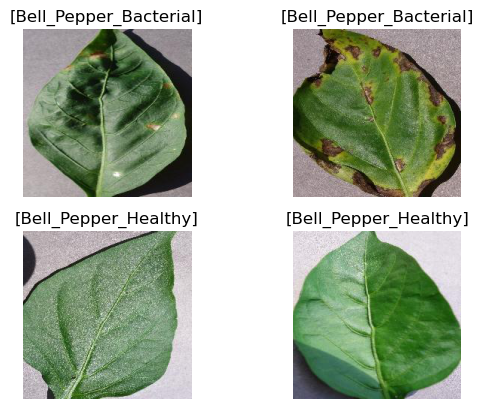

In [24]:
visualize_model(model_hybrid, num_images=batch_size)

In [25]:
criterion = nn.CrossEntropyLoss()
running_loss = 0.0
running_corrects = 0
n_batches = dataset_sizes['val'] // batch_size
it = 0

# more metrics
true_pos = 0
true_neg = 0
false_pos = 0
false_neg = 0

# Testing loop
for inputs, labels in dataloaders['val']:
    model_hybrid.eval()
    inputs = inputs.to(device)
    labels = labels.to(device)
    batch_size_ = len(inputs)
    with torch.set_grad_enabled(False):
        outputs = model_hybrid(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
    running_loss += loss.item() * batch_size_
    batch_corrects = torch.sum(preds == labels.data).item()
    running_corrects += batch_corrects
    
    # more metrics:
    batch_true_pos = torch.sum(preds + labels.data == 2).item()
    batch_true_neg = torch.sum(preds + labels.data == 0).item()
    batch_false_neg = torch.sum(labels.data == 1).item() - batch_true_pos
    batch_false_pos = torch.sum(labels.data == 0).item() - batch_true_neg
    true_pos += batch_true_pos
    true_neg += batch_true_neg
    false_pos += batch_false_pos
    false_neg += batch_false_neg
        
    print('Iter: {}/{}'.format(it + 1, n_batches + 1), end='\r', flush=True)
    it+=1
# Print final results                    
epoch_loss = running_loss / dataset_sizes['val']
epoch_acc = running_corrects / dataset_sizes['val']
print('\nTest Loss: {:.4f} Test Acc: {:.4f}        '.format(epoch_loss, epoch_acc))

Iter: 49/50
Test Loss: 0.1006 Test Acc: 0.9949        


## Some more metrics for our model

In [26]:
# more metrics
print("true positives: ",true_pos)
print("false negatives:", false_neg)
print("true negatives: ", true_neg)
print("false positives:", false_pos)
print('\nTest Loss: {:.4f} Test Acc: {:.4f}        '.format(epoch_loss, epoch_acc))
# precision (positive predictive value), all cmg
print("PPV (precision): {:.4f}  ".format(true_pos/(true_pos+false_pos)))

# negative predictive value, all no cmg
print("NPV:  {:.4f}             ".format(true_neg/(true_neg+false_neg)))

# recall (sensitivity) 
print("recall/sensitivity: {:.4f}".format(true_pos/(true_pos+false_neg)))

# true negative rate (specificity) 
print("specificity: {:.4f}      " .format(true_neg/(true_neg+false_pos)))

# The traditional F-measure or balanced F-score (F1 score)
# is the harmonic mean of precision and recall
print("F1 score:  {:.4f}        ".format(2*true_pos/(2*true_pos + false_pos + false_neg)))

true positives:  98
false negatives: 0
true negatives:  97
false positives: 1

Test Loss: 0.1006 Test Acc: 0.9949        
PPV (precision): 0.9899  
NPV:  1.0000             
recall/sensitivity: 1.0000
specificity: 0.9898      
F1 score:  0.9949        


## References

[1] Andrea Mari, Thomas R. Bromley, Josh Izaac, Maria Schuld, and Nathan Killoran. Transfer learning in hybrid classical-quantum neural networks. https://arxiv.org/abs/1912.08278

[2] Sasank Chilamkurthy. PyTorch transfer learning tutorial. https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html.

[3] Pennylane Quantum Transfer Learning - https://pennylane.ai/qml/demos/tutorial_quantum_transfer_learning.html